# Import Data

In [ ]:
!mkdir ./dataset

!kaggle datasets download robikscube/this-week-in-chess-archive -p ./dataset
!unzip ./dataset/*.zip -d ./dataset/

!kaggle datasets download crxxom/chess-gm-players -p ./dataset
!unzip ./dataset/chess-gm-players.zip -d ./dataset/

Dataset URL: https://www.kaggle.com/datasets/robikscube/this-week-in-chess-archive
License(s): copyright-authors
100% 1.48G/1.48G [01:13<00:00, 26.9MB/s]
100% 1.48G/1.48G [01:13<00:00, 21.6MB/s]
Archive:  ./dataset/this-week-in-chess-archive.zip
  inflating: ./dataset/metadata.csv  
  inflating: ./dataset/pgns/twic1000.pgn  
  inflating: ./dataset/pgns/twic1001.pgn  
  inflating: ./dataset/pgns/twic1002.pgn  
  inflating: ./dataset/pgns/twic1003.pgn  
  inflating: ./dataset/pgns/twic1004.pgn  
  inflating: ./dataset/pgns/twic1005.pgn  
  inflating: ./dataset/pgns/twic1006.pgn  
  inflating: ./dataset/pgns/twic1007.pgn  
  inflating: ./dataset/pgns/twic1008.pgn  
  inflating: ./dataset/pgns/twic1009.pgn  
  inflating: ./dataset/pgns/twic1010.pgn  
  inflating: ./dataset/pgns/twic1011.pgn  
  inflating: ./dataset/pgns/twic1012.pgn  
  inflating: ./dataset/pgns/twic1013.pgn  
  inflating: ./dataset/pgns/twic1014.pgn  
  inflating: ./dataset/pgns/twic1015.pgn  
  inflating: ./dataset/pgns/

In [ ]:
import pandas as pd
chess_data = pd.read_csv("/content/dataset/twic_master.csv")
players_data = pd.read_csv("/content/dataset/GM_players_statistics.csv")

<ipython-input-2-c69d8d190f61>:2: DtypeWarning: Columns (10,13,14,23,25) have mixed types. Specify dtype option on import or set low_memory=False.
  chess_data = pd.read_csv("/content/dataset/twic_master.csv")


# Data preprocessing

Drop rows with NaN values in important columns (player name, date, moves, etc.)

In [ ]:
important_columns = ['White', 'Black', 'Date', 'mainline_moves']

# Filter rows that contain NaN values in any of the important columns
nan_rows = chess_data[chess_data[important_columns].isna().any(axis=1)]
chess_data = chess_data.dropna(subset=important_columns)

print(f"Number of rows with NaN in important columns: {len(nan_rows)}")
print("Examples of rows with NaN values before dropping:")
nan_rows[important_columns].head()

Number of rows with NaN in important columns: 10922
Examples of rows with NaN values before dropping:


White                  Black        Date mainline_moves
75          Guimaraes,D         Shaposhnikov,E  2018-12-26            NaN
394        Rashkovsky,N          Mamatov,Melis  2018-12-26            NaN
556      Shaposhnikov,E               Tissir,M  2018-12-27            NaN
866        Morozevich,A  Abdusattorov,Nodirbek  2018-12-27            NaN
5704  Mafanya,Kulasande       Norinkeviciute,R  2018-12-28            NaN

Check for duplicate entries and drop them

In [ ]:
# Create a game identifier for games by concatenating player names with the date
chess_data['game_identifier'] = chess_data.apply(
    lambda row: tuple([row['White'], row['Black']]) + (row['Date'],),
    axis=1
)

# Count occurrences of each identifier
duplicate_counts = chess_data['game_identifier'].value_counts()

# Identify duplicates
duplicate_identifiers = duplicate_counts[duplicate_counts > 1].index

# Filter DataFrame to show duplicate example
duplicates = chess_data[chess_data['game_identifier'].isin(duplicate_identifiers)]
example = chess_data[chess_data['game_identifier'] == duplicates['game_identifier'].iloc[0]]

# Drop duplicates and keep only one row for each game_identifier
chess_data = chess_data.drop_duplicates(subset='game_identifier', keep='first')

print(f"Number of duplicate entries: {len(duplicate_identifiers)}")
print("Examples of duplicates:")
example

Number of duplicate entries: 28402
Examples of duplicates:


twic_number     White      Black        Date   EventDate  \
5863            1260  Ravi,TeS  Thipsay,B  2018-12-31  2018.12.30   
1603518         1261  Ravi,TeS  Thipsay,B  2018-12-31  2018.12.30   

                             Event Result  \
5863     4th IIFL Wealth Mumbai Op    1-0   
1603518  4th IIFL Wealth Mumbai Op    1-0   

                                            mainline_moves        Site  \
5863     1. d4 f5 2. Nf3 Nf6 3. c4 e6 4. e3 Bb4+ 5. Bd2...  Mumbai IND   
1603518  1. d4 f5 2. Nf3 Nf6 3. c4 e6 4. e3 Bb4+ 5. Bd2...  Mumbai IND   

         Online  ... WhiteTeam BlackTeam EventType  FEN SetUp  Variant  Board  \
5863      False  ...       NaN       NaN       NaN  NaN   NaN      NaN    NaN   
1603518   False  ...       NaN       NaN       NaN  NaN   NaN      NaN    NaN   

        PlyCount EventCategory                    game_identifier  
5863         NaN           NaN  (Ravi,TeS, Thipsay,B, 2018-12-31)  
1603518      NaN           NaN  (Ravi,TeS, Thipsay,B, 2018-12-31)  

[2 rows x 30 columns]

Identify False data

In [ ]:
chess_data['Year'] = chess_data['Date'].map(lambda x: str(x)[:4])
print(chess_data['Year'].unique())

['2018' '2017' '2015' '2014' '2020' '2016' '2013' '2012' '2022' '2021'
 '2019' '2005' '1988' '2029' '2011' '2010']


In [ ]:
relevent_years = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022']
print(f"Number of rows with irrelevent year removed: {len(chess_data[~chess_data['Year'].isin(relevent_years)])}")
chess_data=chess_data[chess_data['Year'].isin(relevent_years)]

Number of rows with irrelevent year removed: 3


Determine the winner of each match

In [ ]:
def determine_winner(result):
    if result == "1-0":
        return "white"
    elif result == "0-1":
        return "black"
    elif result == "1/2-1/2":
        return "tie"
    else:
        return None  # In case of any unexpected result format

# Step 1: Apply the function to create a new 'winner' column
chess_data['Winner'] = chess_data['Result'].apply(determine_winner)

Also note there are a lot of variants and names for essentially similar openings

In [ ]:
chess_data['Opening'].unique()

array(['Sicilian', 'Reti opening', "Petrov's defence", 'Robatsch defence',
       'Dutch with c4 & Nc3',
       "Two knights defence (Modern bishop's opening)", 'Gruenfeld',
       'Giuoco Piano', 'QGD', 'Ruy Lopez', 'English opening', 'QGD Slav',
       "King's Indian", 'Sicilian, Chekhover variation', 'French',
       'Trompovsky attack (Ruth, Opovcensky opening)', 'Nimzo-Indian',
       'Bogo-Indian defence', 'QGA', 'Giuoco Pianissimo', 'Caro-Kann',
       'Catalan', "Bishop's opening", 'Sicilian defence', 'Reti',
       'Old Indian defence', "Queen's gambit declined",
       'Bogo-Indian defence, Nimzovich variation', "King's pawn opening",
       'QGD semi-Slav', 'Pirc', 'Robatsch (modern) defence',
       'QGD Slav defence', 'Scandinavian (centre counter) defence',
       "Queen's Indian", 'English', 'Scotch', 'Two knights defence',
       'Philidor', "King's Indian, 3.Nf3", "Queen's Pawn",
       "Alekhine's defence", 'Catalan opening', 'Scotch game',
       "Queen's pawn game",

Therefore, for our cause we will remove the variants name and focus on the main form of openings (Sicilian,Four Knights, Queen's, etc.)

In [ ]:
import pandas as pd
import re

# List of general openings
general_openings = ["Alekhine", "Benko", "Benoni", "Bird", "Bogo-Indian",
                    "Budapest", "Catalan", "Caro-Kann", "Colle System", "Dutch",
                    "Giuoco Piano", "English", "Evans", "Knights", "French",
                    "Gruenfeld", "Italian", "King", "London System", "Modern",
                    "Nimzo-Indian", "Nimzowitsch", "Petrov’s", "Philidor’s",
                    "Pirc", "Queen", "Reti", "Ruy Lopez", "Scandinavian", "Scotch",
                    "Sicilian", "Slav", "Torre", "Vienna", "Wade", "qg",
                    "Giuoco Pianissimo", "trompovsky", "philidor", "robatsch", "bishop",
                    "petrov", "nimzovich-larsen", "mieses", "kp", "old indian", "hungarian",
                    "van't kruijs", "richter-veresov", "dzindzikhashvili", "anderssen",
                    "dunst", "grob", "kg", "lengfellner system", "polish", "latvian",
                    "blumenfeld", "blackmar-diemer", "st. george", "kevitz-trajkovich", "beefeater",
                    "centre", "owen", "battambang", "qp", "anti-borg", "ponziani", "gunderam",
                    "danish", "konstantinopolsky", "saragossa", "hanham", "paleface", "damiano",
                    "blackmar", "lasker simul", "boden-kieseritsky", "tennison", "clemenz", "gedult"]

abbreviation_map = {
    "qp": "queen",
    "qg": "queen",
    "kp": "king",
    "kg": "king"
}

# Normalize opening names (lowercase and remove spaces)
general_openings = [opening.lower().replace("’", "'") for opening in general_openings]

# Mapping function to assign the general opening name
def map_opening_to_general(opening):
    opening = str(opening)
    opening_normalized = opening.lower().replace("’", "'")  # Normalize
    for general_opening in general_openings:
        if re.search(r'\b' + re.escape(general_opening) + r'\b', opening_normalized):
            return general_opening
    return None  # If no match is found

# Apply abbreviation mapping after general opening mapping
def map_shortcut_to_full_name(opening):
    return abbreviation_map.get(opening, opening)

# Apply the mapping to the chess data
chess_data['Opening'] = chess_data['Opening'].apply(map_opening_to_general)
chess_data['Opening'] = chess_data['Opening'].apply(map_shortcut_to_full_name)

In [ ]:
chess_data['Country'] = chess_data['Site'].apply(lambda x: x.split()[-1])
country_code_to_name = {
    "RUS": "Russia", "ITA": "Italy", "FRA": "France", "DEU": "Germany", "ESP": "Spain", "INT": "Internet",
    "GBR": "United Kingdom", "USA": "United States of America", "CAN": "Canada", "AUS": "Australia",
    "CHN": "China", "IND": "India", "BRA": "Brazil", "JPN": "Japan", "KOR": "South Korea",
    "ARG": "Argentina", "MEX": "Mexico", "POL": "Poland", "NLD": "Netherlands", "BEL": "Belgium",
    "SWE": "Sweden", "SUI": "Switzerland", "UKR": "Ukraine", "FIN": "Finland", "AUT": "Austria",
    "CZE": "Czech Republic", "CHL": "Chile", "LIT": "Lithuania", "LAT": "Latvia", "THA": "Thailand",
    "ISR": "Israel", "IRL": "Ireland", "CRO": "Croatia", "ROU": "Romania", "BUL": "Bulgaria",
    "KAZ": "Kazakhstan", "GEO": "Georgia", "GRE": "Greece", "POR": "Portugal", "ISL": "Iceland",
    "MNE": "Montenegro", "SRB": "Serbia", "MKD": "North Macedonia", "ARM": "Armenia", "NZL": "New Zealand",
    "UGA": "Uganda", "URU": "Uruguay", "PER": "Peru", "CUB": "Cuba", "RSA": "South Africa",
    "KSA": "Saudi Arabia", "LBN": "Lebanon", "DOM": "Dominican Republic", "KOS": "Kosovo", "BOL": "Bolivia",
    "TUN": "Tunisia", "MAR": "Morocco", "SUD": "Sudan", "NEP": "Nepal", "EGY": "Egypt", "GHA": "Ghana",
    "IRQ": "Iraq", "VEN": "Venezuela", "KEN": "Kenya", "PHI": "Philippines", "QAT": "Qatar", "SRI": "Sri Lanka",
    "FIJ": "Fiji", "ZAM": "Zambia", "CIV": "Ivory Coast", "PAN": "Panama", "LUX": "Luxembourg",
    "ECU": "Ecuador", "LIE": "Liechtenstein", "TRI": "Trinidad and Tobago", "CRC": "Costa Rica", "CYP": "Cyprus",
    "PUR": "Puerto Rico", "GAM": "Gambia", "MLT": "Malta", "SLE": "Sierra Leone", "GUA": "Guatemala",
    "SVK": "Slovakia", "ENG": "England", "JCI": "Internet", "Labem": "Czech Republic", "BAR": "Barbados",
    "AND": "Andorra", "KOS": "Kosovo", "LTU": "Lithuania", "BOL": "Bolivia", "TUN": "Tunisia", "ALB": "Albania",
    "TAN": "Tanzania", "MGL": "Mongolia", "KGZ": "Kyrgyzstan", "SUR": "Suriname", "MYA": "Myanmar",
    "MNC": "Macedonia", "SMR": "San Marino", "SYR": "Syria", "SEY": "Seychelles", "GUM": "Guam", "BOT": "Botswana"
}

# Step 6: Map country codes in the dataframe to country names
chess_data['Country'] = chess_data['Country'].map(country_code_to_name)

# Data visualization

## Distribution visualizations

### Pie chart of countries

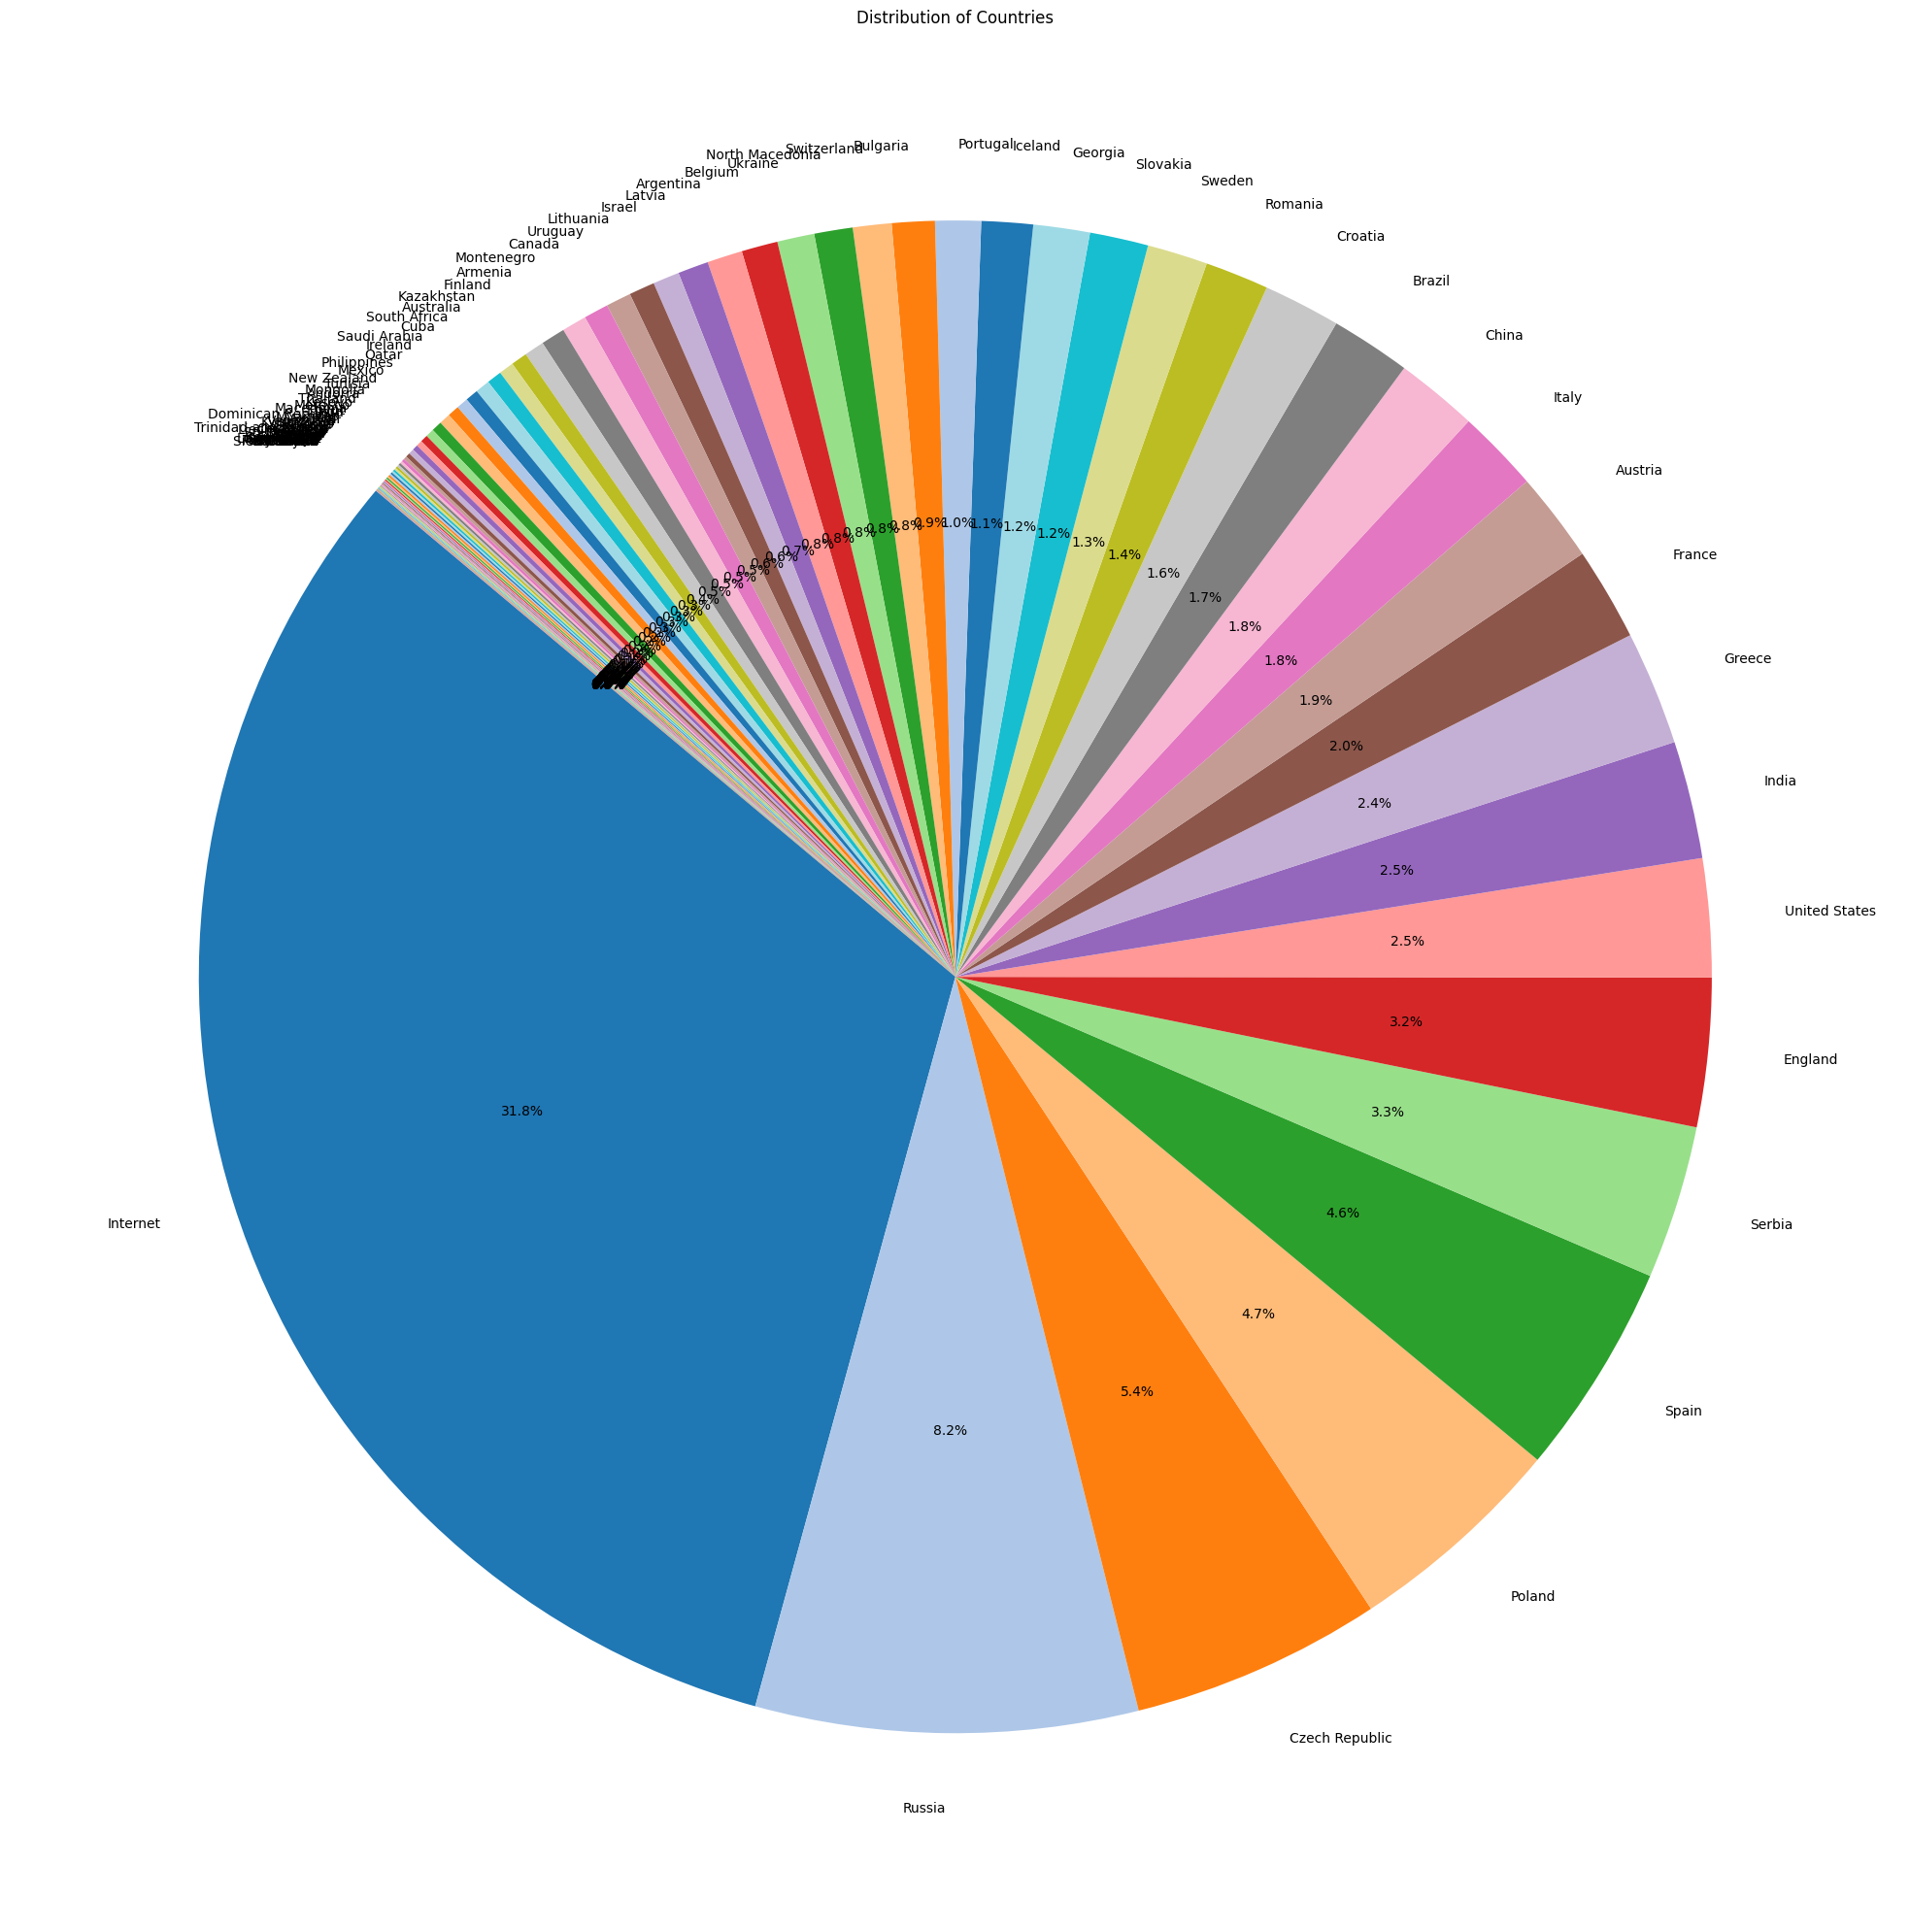

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd

# Assuming chess_data is already loaded
country_counts = chess_data['Country'].value_counts()

# Generate unique colors for each country
colors = cm.tab20.colors  # Use a colormap with diverse colors
unique_colors = [colors[i % len(colors)] for i in range(len(country_counts))]

# Plot the pie chart
plt.figure(figsize=(20, 20))
country_counts.plot.pie(
    autopct='%1.1f%%',
    startangle=140,
    colors=unique_colors,
    legend=False
)
plt.title("Distribution of Countries")
plt.ylabel('')  # Remove y-axis label for aesthetics
plt.tight_layout()
plt.show()

### Pie chart of openings

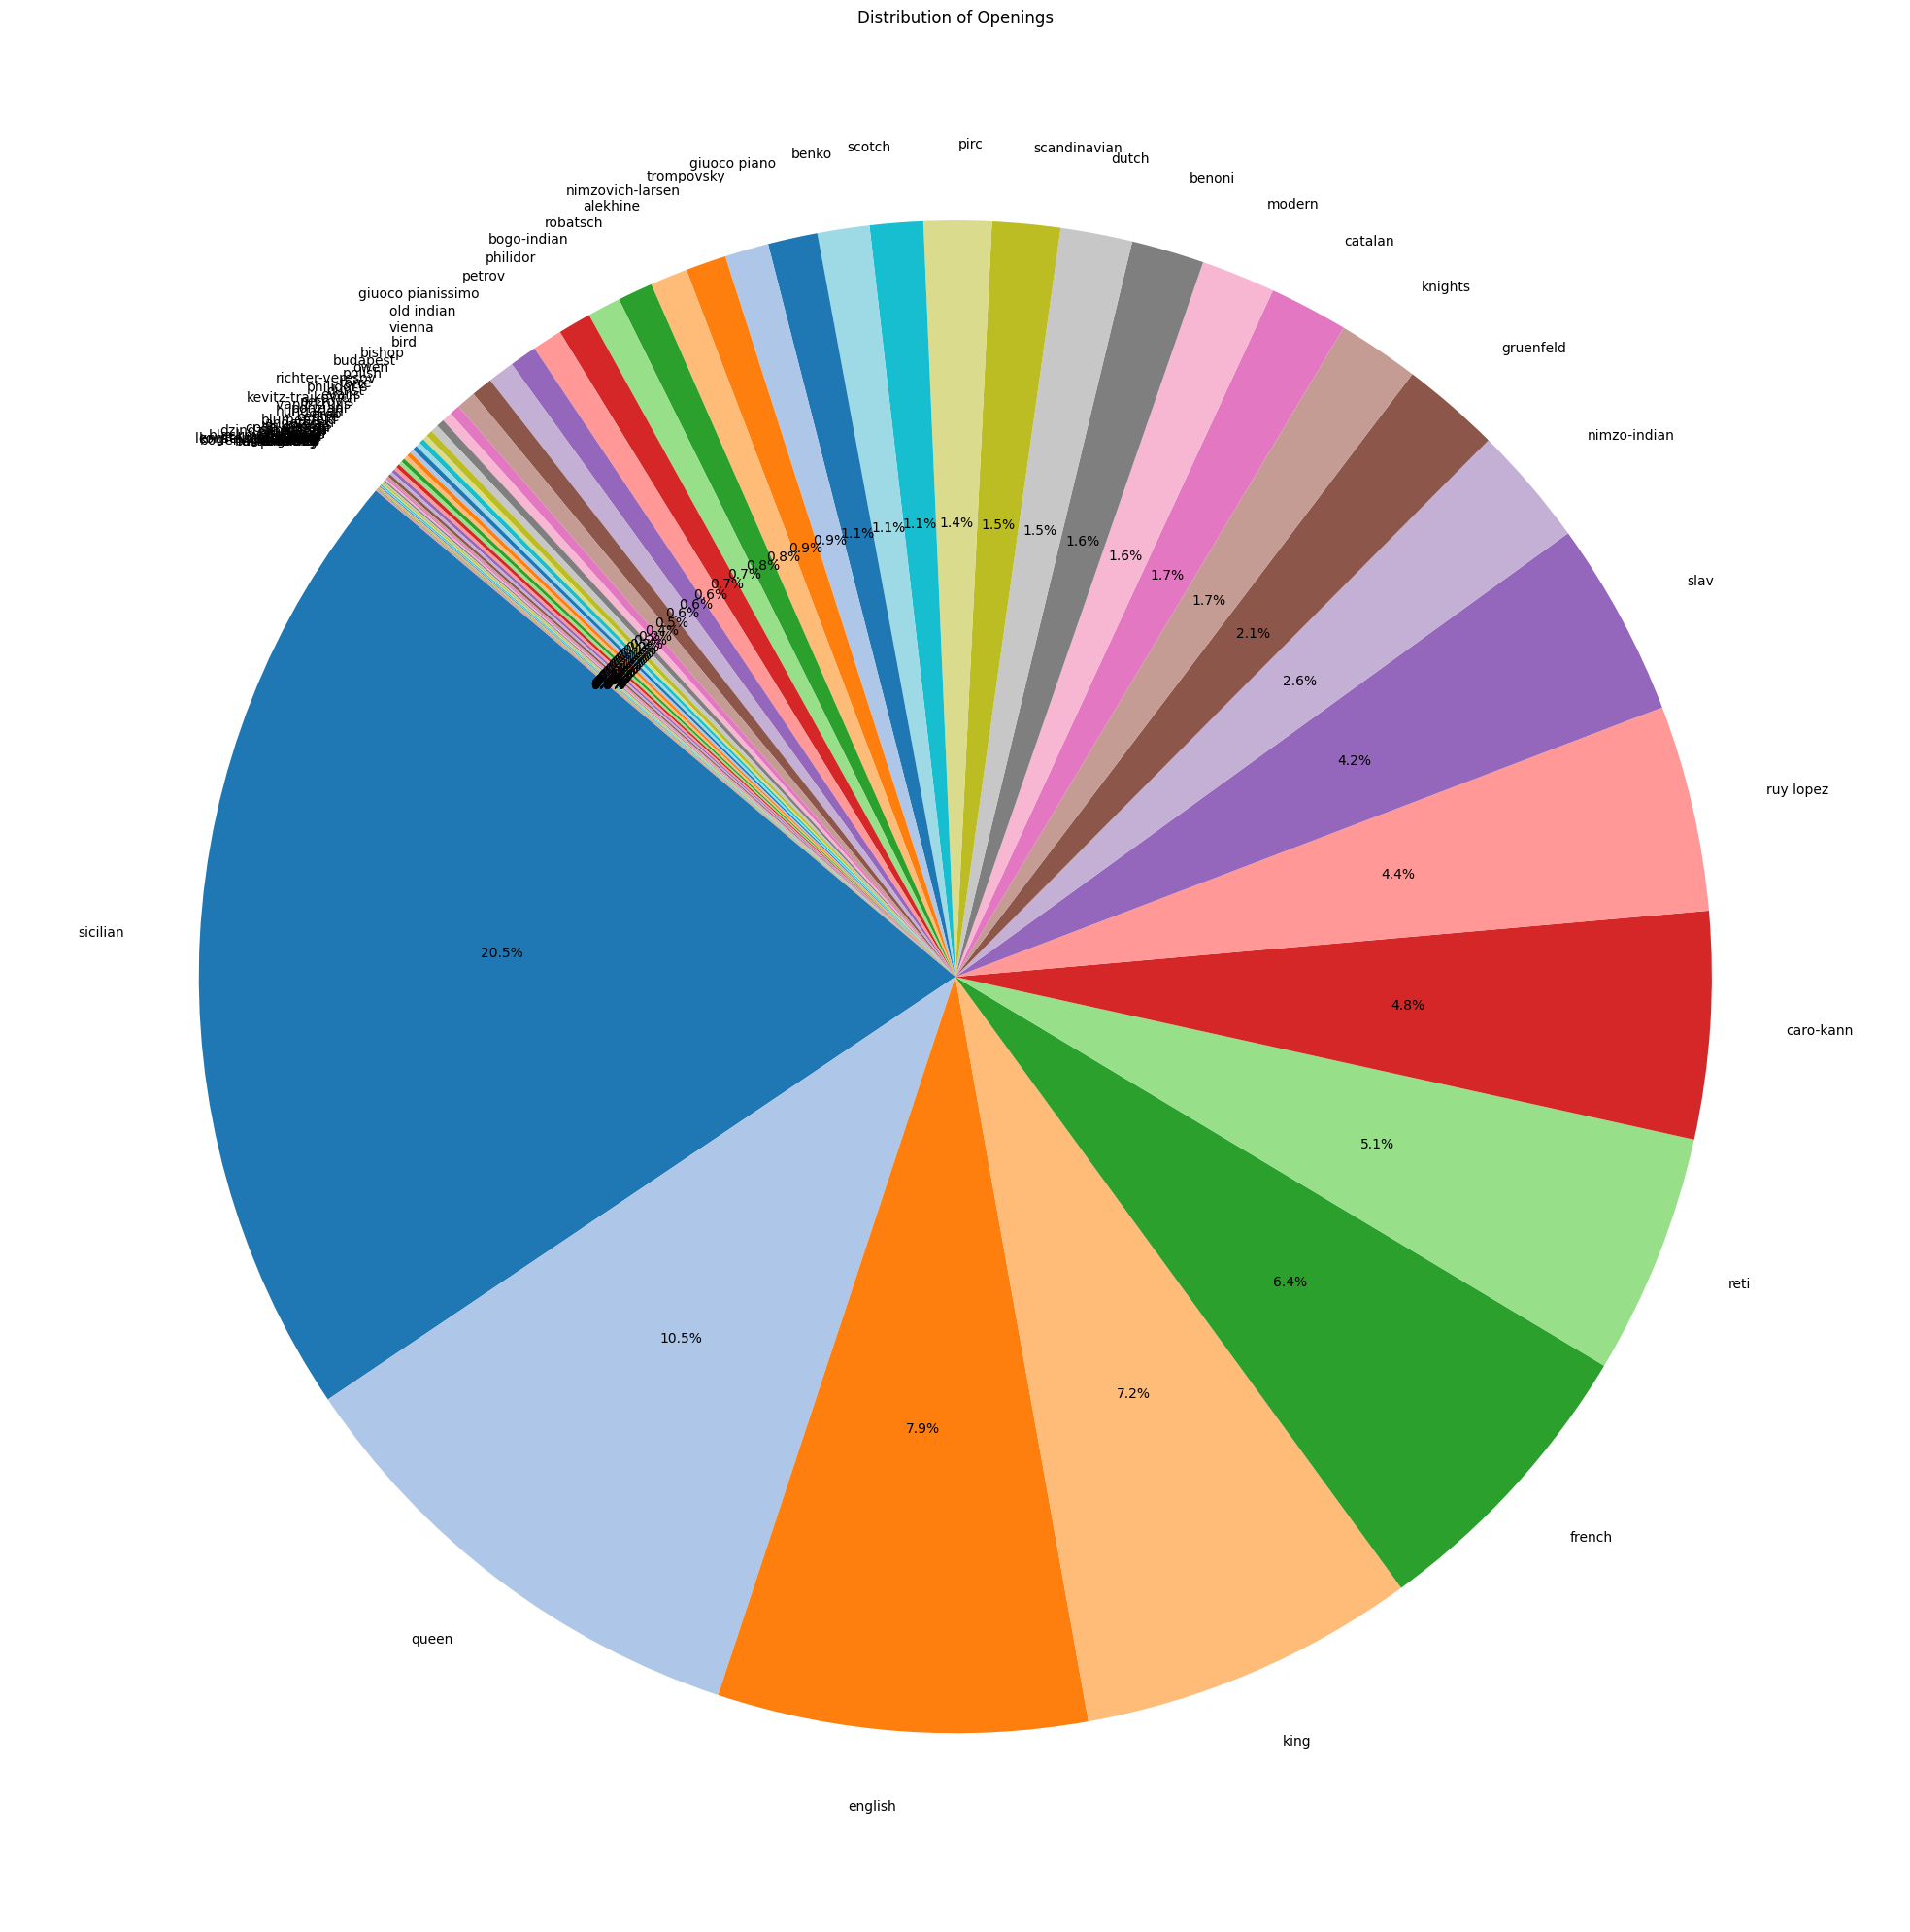

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd

opening_counts = chess_data['Opening'].value_counts()

# Generate unique colors for each opening
colors = cm.tab20.colors  # Use a colormap with diverse colors
unique_colors = [colors[i % len(colors)] for i in range(len(opening_counts))]

# Plot the pie chart
plt.figure(figsize=(20, 20))
opening_counts.plot.pie(
    autopct='%1.1f%%',
    startangle=140,
    colors=unique_colors,
    legend=False
)
plt.title("Distribution of Openings")
plt.ylabel('')  # Remove y-axis label for aesthetics
plt.tight_layout()
plt.show()

## Temporal visualizations

### Top 10 chess openings over the years

<ipython-input-29-3a3ef2767ec8>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_openings_data['rank'] = top_openings_data.groupby('Year')['count'].rank(method='first', ascending=False)
<ipython-input-29-3a3ef2767ec8>:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', num_openings)  # Use a larger colormap (tab20) for more colors


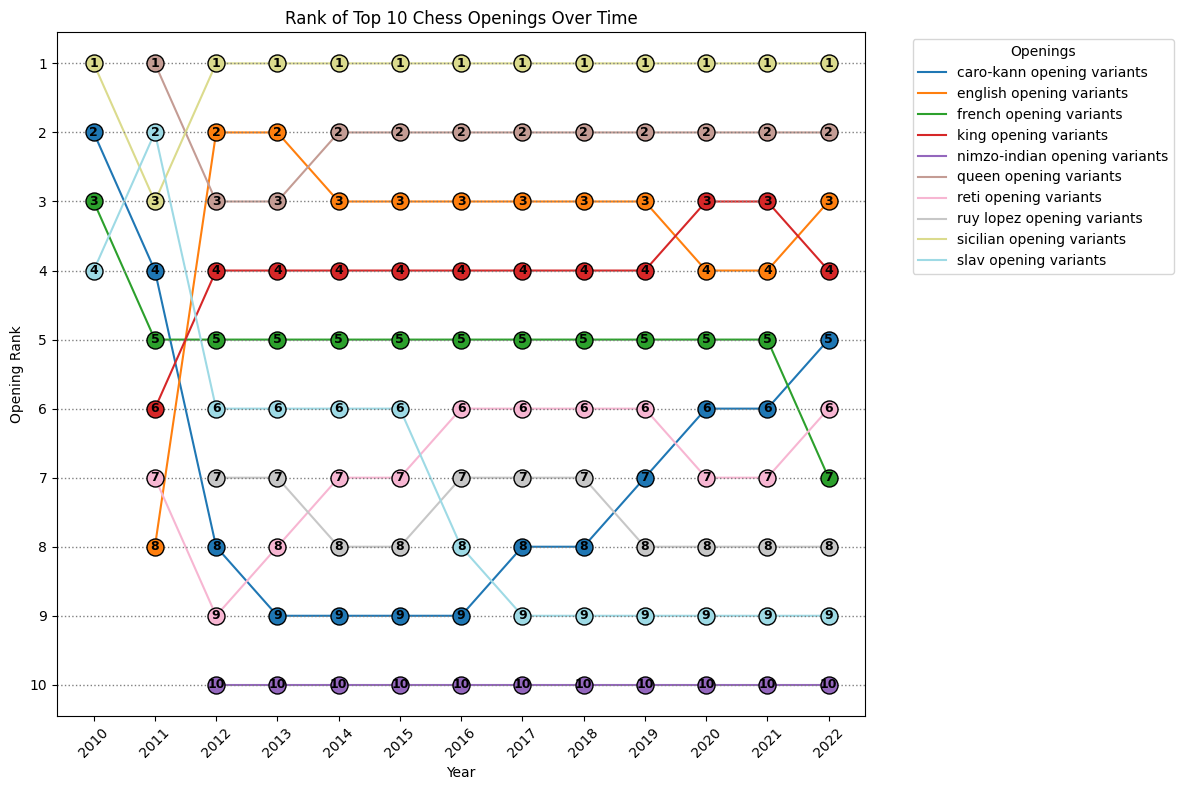

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Count the number of occurrences of each opening per year
opening_count_per_year = chess_data.groupby(['Opening', 'Year']).size().reset_index(name='count')

# Step 2: Get the top 10 openings based on total count across all years
top_10_openings = opening_count_per_year.groupby('Opening')['count'].sum().nlargest(10).index

# Step 3: Filter the data to include only the top 10 openings
top_openings_data = opening_count_per_year[opening_count_per_year['Opening'].isin(top_10_openings)]

# Step 4: For each year, assign a rank to each opening based on the number of occurrences.
# Adjust the ranking logic to avoid gaps by using 'groupby' and 'rank' for each year individually.
top_openings_data['rank'] = top_openings_data.groupby('Year')['count'].rank(method='first', ascending=False)

# Step 5: Plot the trends of ranks over time
plt.figure(figsize=(12, 8))

# Create a colormap with enough distinct colors for all openings
num_openings = len(top_openings_data['Opening'].unique())
colors = plt.cm.get_cmap('tab20', num_openings)  # Use a larger colormap (tab20) for more colors

# Plot each of the top 10 openings as a line (using the rank over the years)
for idx, opening in enumerate(top_openings_data['Opening'].unique()):
    opening_data = top_openings_data[top_openings_data['Opening'] == opening]

    # Plot the line for rank over years
    plt.plot(opening_data['Year'], opening_data['rank'], label=f"{opening} opening variants", color=colors(idx))

    # Plot the white dots for each year with the rank number inside
    plt.scatter(opening_data['Year'], opening_data['rank'], color=colors(idx), edgecolor='black', zorder=5, s=150)
    for i, row in opening_data.iterrows():
        # Add rank number inside the dot, adjusting position with ha='center' and va='center'
        plt.text(row['Year'], row['rank'], str(int(row['rank'])), fontsize=9, ha='center', va='center', color='black', fontweight='bold', zorder=10)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Opening Rank')
plt.title('Rank of Top 10 Chess Openings Over Time')

# Set y-ticks explicitly to be from 1 to 10 (rank 1 at the top)
plt.yticks(range(1, 11))  # Set ticks from 1 to 10 (higher rank is 1)

# Add dotted lines for each y-tick
for rank in range(1, 11):
    plt.axhline(y=rank, color='gray', linestyle=':', linewidth=1)  # Dotted line at each rank

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Invert the y-axis so rank 1 is at the top and rank 10 at the bottom
plt.gca().invert_yaxis()

# Display the plot
plt.legend(title='Openings', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Top 10 players (by ELO) over the years

<ipython-input-35-9cc51ad4000d>:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_10_per_year = top_10_per_year.groupby('Year').apply(lambda x: x.nlargest(10, 'ELO')).reset_index(drop=True)


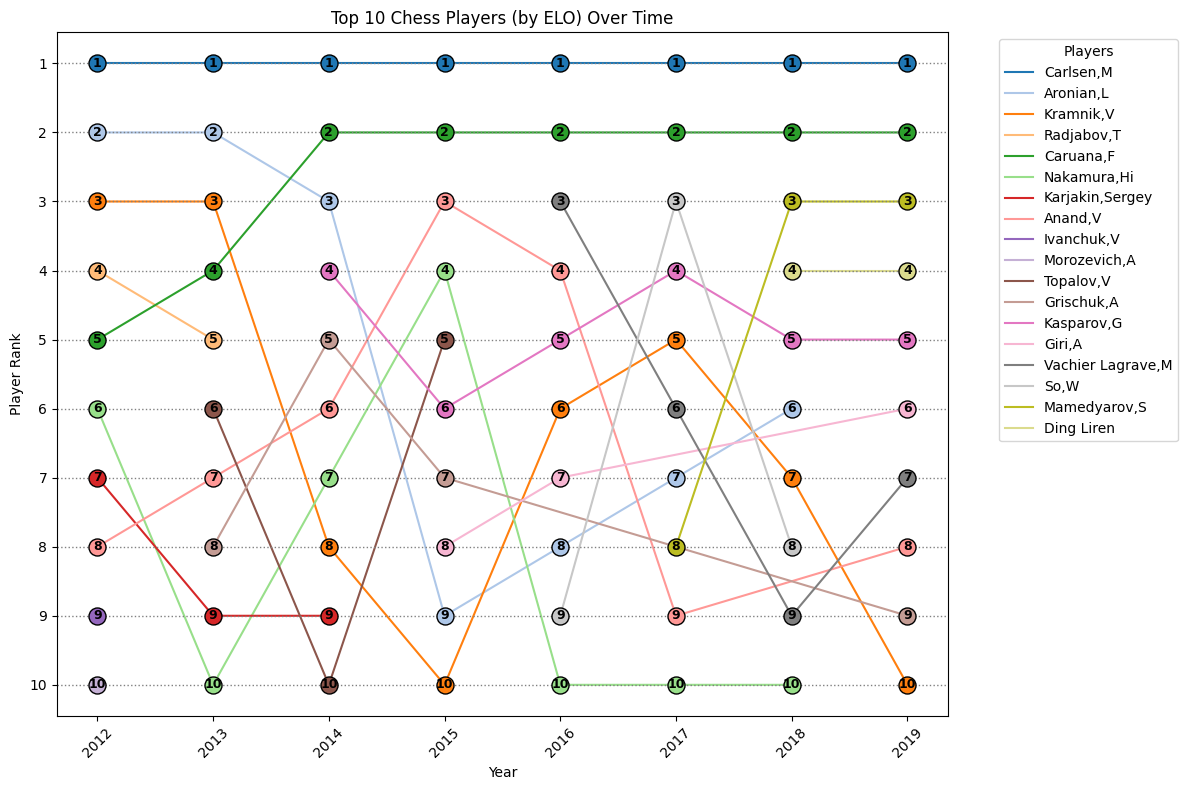

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Aggregate the ELO ratings for both White and Black players by Year
elo_data = pd.concat([
    chess_data[['Year', 'White', 'WhiteElo']].rename(columns={'White': 'Player', 'WhiteElo': 'ELO'}).reset_index(drop=True),
    chess_data[['Year', 'Black', 'BlackElo']].rename(columns={'Black': 'Player', 'BlackElo': 'ELO'}).reset_index(drop=True)
])

# Step 2: For each year, find the top 10 players by ELO
top_10_per_year = elo_data.groupby(['Year', 'Player'])['ELO'].max().reset_index()  # Get max ELO for each player per year
top_10_per_year = top_10_per_year.groupby('Year').apply(lambda x: x.nlargest(10, 'ELO')).reset_index(drop=True)

# Step 3: Calculate the rank for each player by year
top_10_per_year['rank'] = top_10_per_year.groupby('Year')['ELO'].rank(method='first', ascending=False)

# Step 4: Filter the data to only include years between 2012 and 2019
years = ['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']
top_10_per_year_filtered = top_10_per_year[top_10_per_year['Year'].isin(years)]

# Step 5: Plot the rank trends of the top 10 players from 2012 to 2019
plt.figure(figsize=(12, 8))

# Create a colormap with enough distinct colors for all players
colors = plt.cm.tab20.colors  # Use a colormap with diverse colors
unique_colors = [colors[i % len(colors)] for i in range(top_10_per_year['Player'].nunique())]

# Plot each player's rank over the years
for idx, player in enumerate(top_10_per_year_filtered['Player'].unique()):
    player_data = top_10_per_year_filtered[top_10_per_year_filtered['Player'] == player]

    # Plot the rank over years
    plt.plot(player_data['Year'], player_data['rank'], label=f"{player}", color=unique_colors[idx])

    # Plot the white dots for each year with the rank number inside
    plt.scatter(player_data['Year'], player_data['rank'], color=unique_colors[idx], edgecolor='black', zorder=5, s=150)
    for i, row in player_data.iterrows():
        plt.text(row['Year'], row['rank'], str(int(row['rank'])), fontsize=9, ha='center', va='center', color='black', fontweight='bold', zorder=10)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Player Rank')
plt.title('Top 10 Chess Players (by ELO) Over Time')

# Set y-ticks explicitly to be from 1 to 10 (rank 1 at the top)
plt.yticks(range(1, 11))  # Set ticks from 1 to 10 (higher rank is 1)

# Add dotted lines for each y-tick
for rank in range(1, 11):
    plt.axhline(y=rank, color='gray', linestyle=':', linewidth=1)  # Dotted line at each rank

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Invert the y-axis so rank 1 is at the top and rank 10 at the bottom
plt.gca().invert_yaxis()

# Display the plot
plt.legend(title='Players', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Result distribution over the years

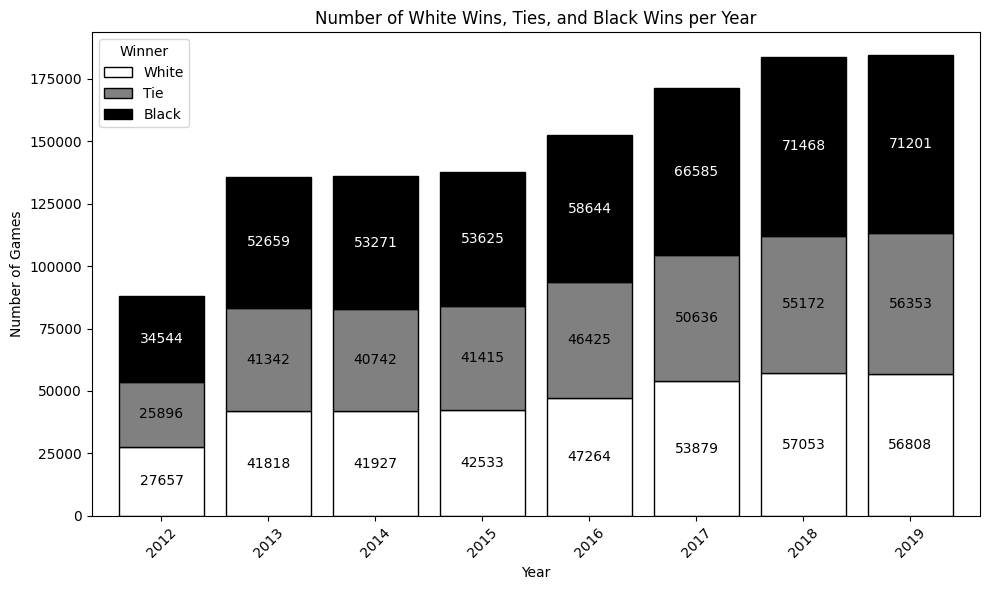

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

years = ['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']
matches_per_year = chess_data[chess_data['Year'].isin(years)]

# Step 2: Group by year and count the number of white wins, ties, and black wins
win_counts = matches_per_year.groupby(['Year', 'Winner']).size().unstack(fill_value=0)

# Step 3: Plot a stacked bar chart
ax = win_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['white', 'gray', 'black'], edgecolor='black', width=0.8)

# Step 4: Add the numbers inside each bar
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        text_color = 'white' if p.get_facecolor() == (0, 0, 0, 1) else 'black'
        ax.text(p.get_x() + p.get_width() / 2, p.get_y() + height / 2,
                f'{int(height)}', ha='center', va='center', color=text_color)

# Step 5: Customize the plot
plt.title('Number of White Wins, Ties, and Black Wins per Year')
plt.xlabel('Year')
plt.ylabel('Number of Games')
plt.xticks(rotation=45)
plt.legend(title='Winner', labels=['White', 'Tie', 'Black'])

# Step 6: Display the plot
plt.tight_layout()
plt.show()


### Online vs. offline matches over the years

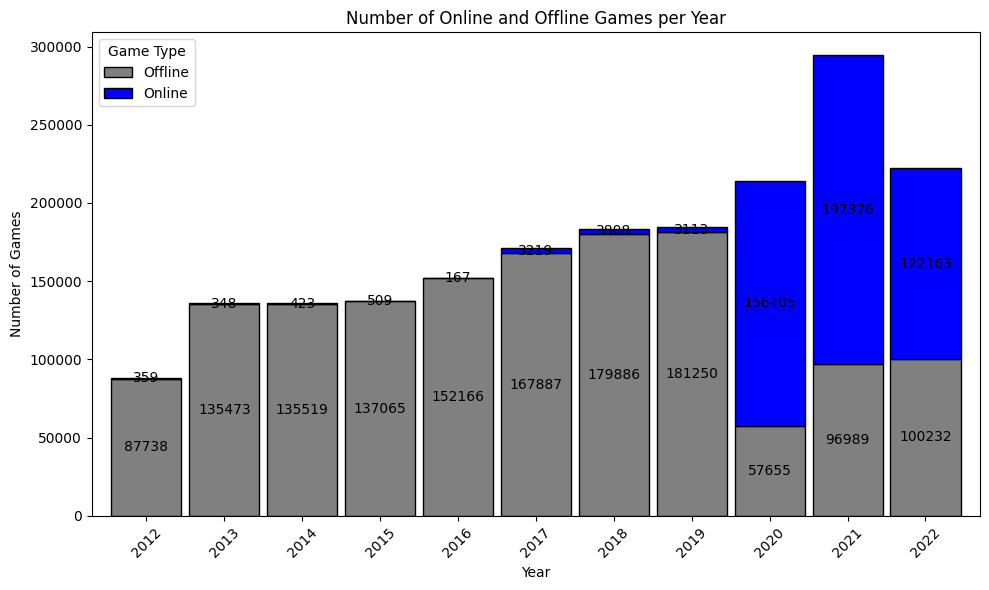

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 2: Group by year and Online status, and count occurrences
years = ['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022']
matches_per_year = chess_data[chess_data['Year'].isin(years)]
online_counts = matches_per_year.groupby(['Year', 'Online']).size().unstack(fill_value=0)

# Step 3: Plot a stacked bar chart with wider bars
ax = online_counts.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color=['gray', 'blue'],
    edgecolor='black',
    width=0.9  # Increase the width of the bars
)

# Step 4: Add numbers inside each bar
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(
            p.get_x() + p.get_width() / 2,  # Center of the bar
            p.get_y() + height / 2,        # Center of the bar's height
            f'{int(height)}',              # Number text
            ha='center', va='center',
            color='black'
        )

# Step 5: Customize the plot
plt.title('Number of Online and Offline Games per Year')
plt.xlabel('Year')
plt.ylabel('Number of Games')
plt.xticks(rotation=45)
plt.legend(title='Game Type', labels=['Offline', 'Online'])

# Step 6: Display the plot
plt.tight_layout()
plt.show()

## Geographical visualizations

### Number of chess matches per country

In [ ]:
import folium
from collections import Counter
import pandas as pd

# Step 3: Count the occurrences of each country
country_counts = Counter(chess_data['Country'])

# Step 4: Convert the count data into a DataFrame
country_counts_df = pd.DataFrame(country_counts.items(), columns=["Country", "Count"])

# Step 7: Filter out rows where mapping failed (if there are any invalid country codes)
country_counts_df = country_counts_df.dropna(subset=['Country'])

# Step 8: Load a GeoJSON file for country borders
world_geo = "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json"

# Step 9: Map visualization using Folium
map_matches = folium.Map(location=[20, 0], zoom_start=2)  # Global-centered map for countries

# Step 10: Add a choropleth layer
folium.Choropleth(
    geo_data=world_geo,
    data=country_counts_df,
    columns=["Country", "Count"],
    key_on="feature.properties.name",  # Ensure the name key matches the GeoJSON format
    fill_color="YlGnBu",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Number of Matches"
).add_to(map_matches)

# Step 11: Display the map
map_matches

### Number of GMs per country

In [ ]:
initial_row_count = len(players_data)

# Extract the last name and drop duplicates
players_data = players_data[~players_data['name'].str.contains('engine', case=False, na=False)]
players_data['last_name'] = players_data['name'].apply(lambda x: x.split()[-1] if isinstance(x, str) else '')
players_data = players_data.drop_duplicates(subset=['last_name'])

# Calculate and print how many rows were deleted
deleted_rows = initial_row_count - len(players_data)
print(f"Number of rows deleted: {deleted_rows}")

Number of rows deleted: 431


<ipython-input-63-c08a528ebf72>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players_data['last_name'] = players_data['name'].apply(lambda x: x.split()[-1] if isinstance(x, str) else '')


In [ ]:
import folium
from collections import Counter
import pandas as pd

# Step 1: Count the occurrences of each country in players_data
country_counts = Counter(players_data['country'])

# Step 2: Convert the count data into a DataFrame
country_counts_df = pd.DataFrame(country_counts.items(), columns=["Country", "Count"])

# Step 3: Load a GeoJSON file for country borders
world_geo = "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json"

# Step 4: Map visualization using Folium
map_players = folium.Map(location=[20, 0], zoom_start=2)  # Global-centered map for countries

# Step 5: Add a choropleth layer
folium.Choropleth(
    geo_data=world_geo,
    data=country_counts_df,
    columns=["Country", "Count"],
    key_on="feature.properties.name",  # Ensure the name key matches the GeoJSON format
    fill_color="YlGnBu",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Number of Players"
).add_to(map_players)

# Step 6: Display the map
map_players

## Correlation visualizations

### Correlation between opening and winner result

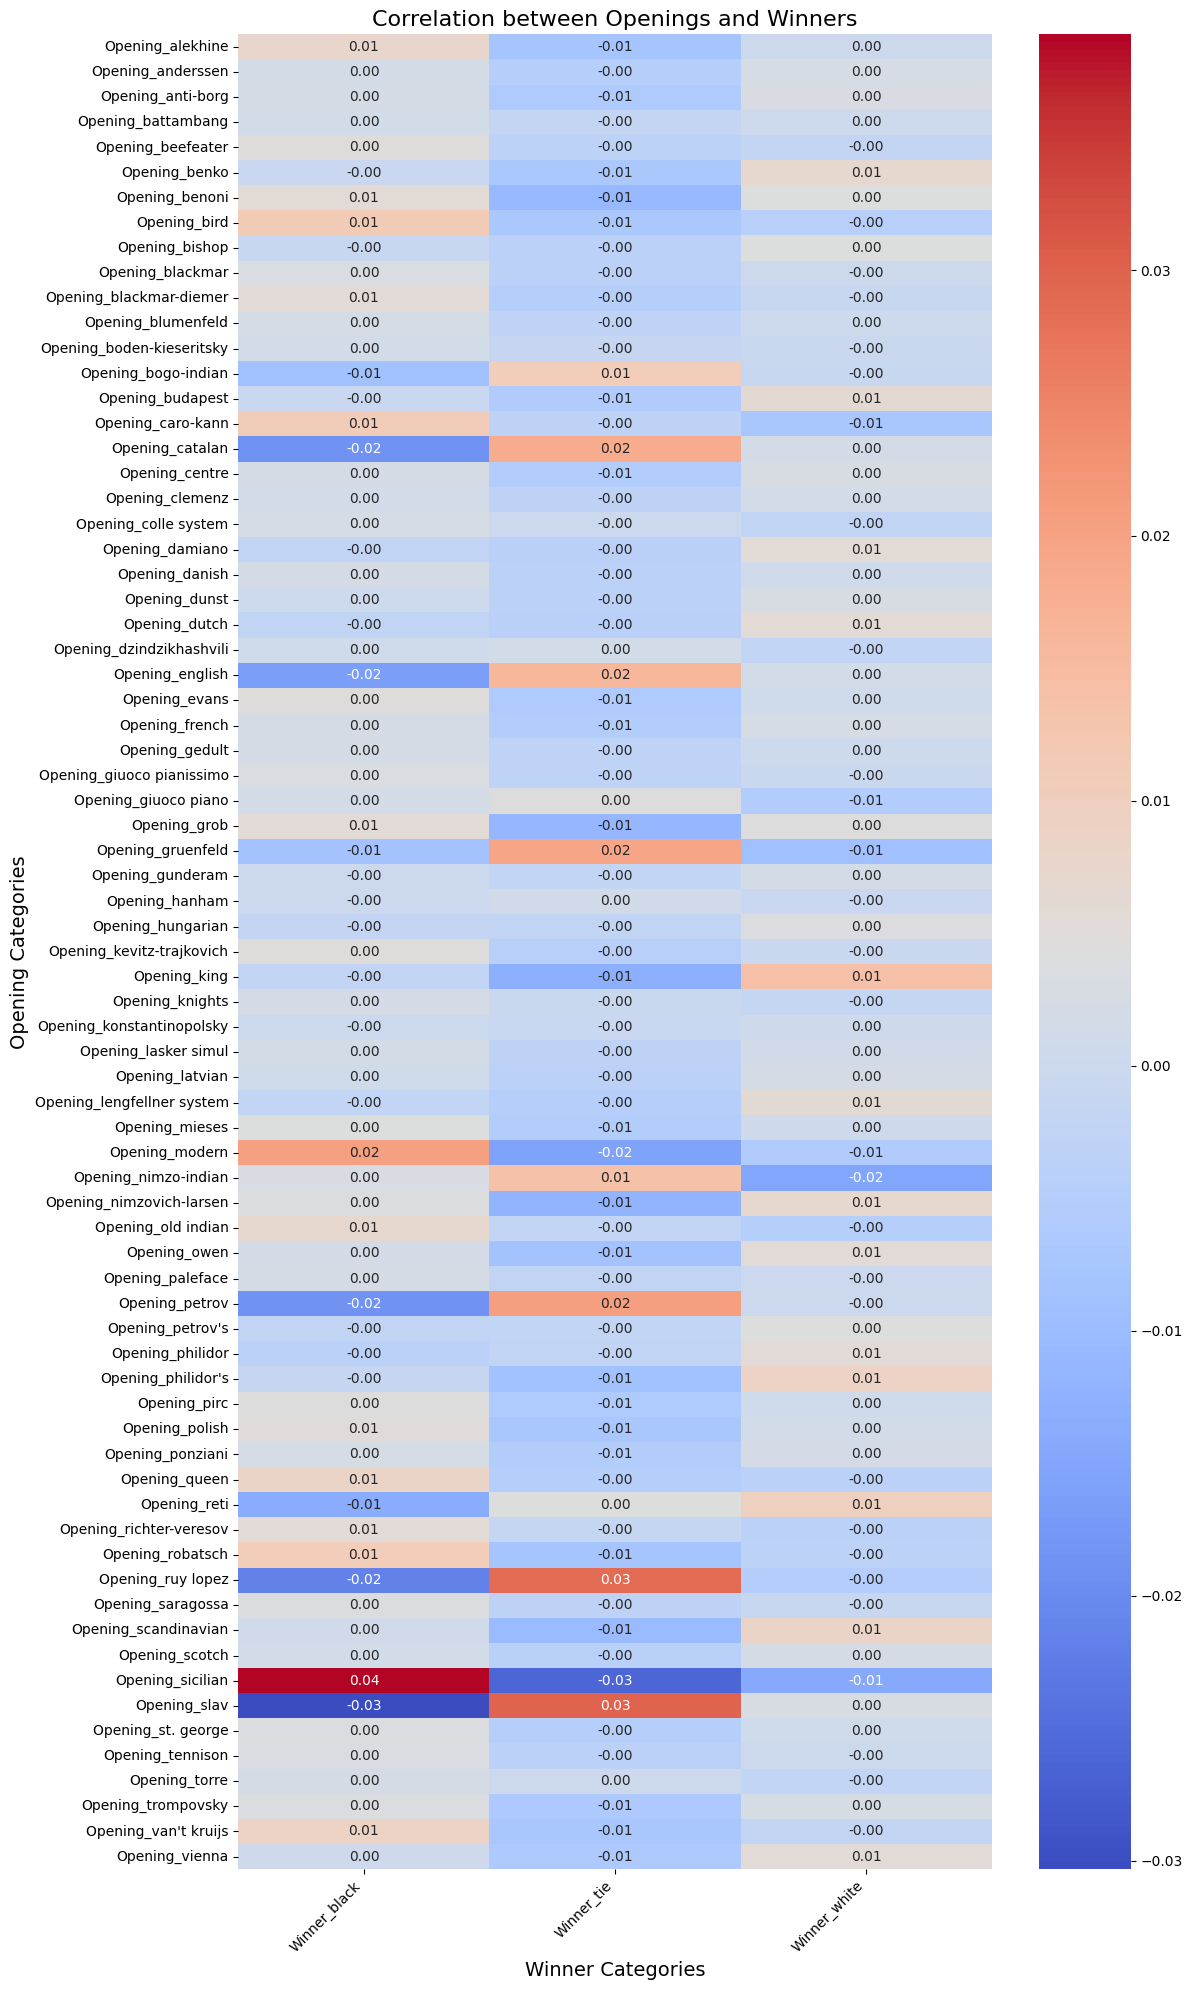

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: One-hot encode the 'Opening' and 'Winner' columns
chess_data_encoded = pd.get_dummies(chess_data[['Opening', 'Winner']], columns=['Opening', 'Winner'])

# Step 2: Extract the relevant one-hot encoded columns (only the ones for Opening and Winner)
opening_columns = [col for col in chess_data_encoded.columns if col.startswith('Opening')]
winner_columns = [col for col in chess_data_encoded.columns if col.startswith('Winner')]

# Step 3: Calculate the correlation matrix only for these two groups
correlation_subset = chess_data_encoded[opening_columns + winner_columns].corr()

# Step 4: Extract only the correlations between Opening and Winner columns
correlation_between_opening_and_winner = correlation_subset.loc[opening_columns, winner_columns]

# Step 5: Plot the correlation heatmap with a larger figure size
plt.figure(figsize=(12, 20))  # Increase the size of the plot
sns.heatmap(correlation_between_opening_and_winner, cmap='coolwarm', annot=True, cbar=True, fmt='.2f')

# Step 6: Rotate axis labels for better readability
plt.title('Correlation between Openings and Winners', fontsize=16)
plt.xlabel('Winner Categories', fontsize=14)
plt.ylabel('Opening Categories', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Step 7: Display the plot
plt.tight_layout()
plt.show()

### Correlation between opening and ELO rating

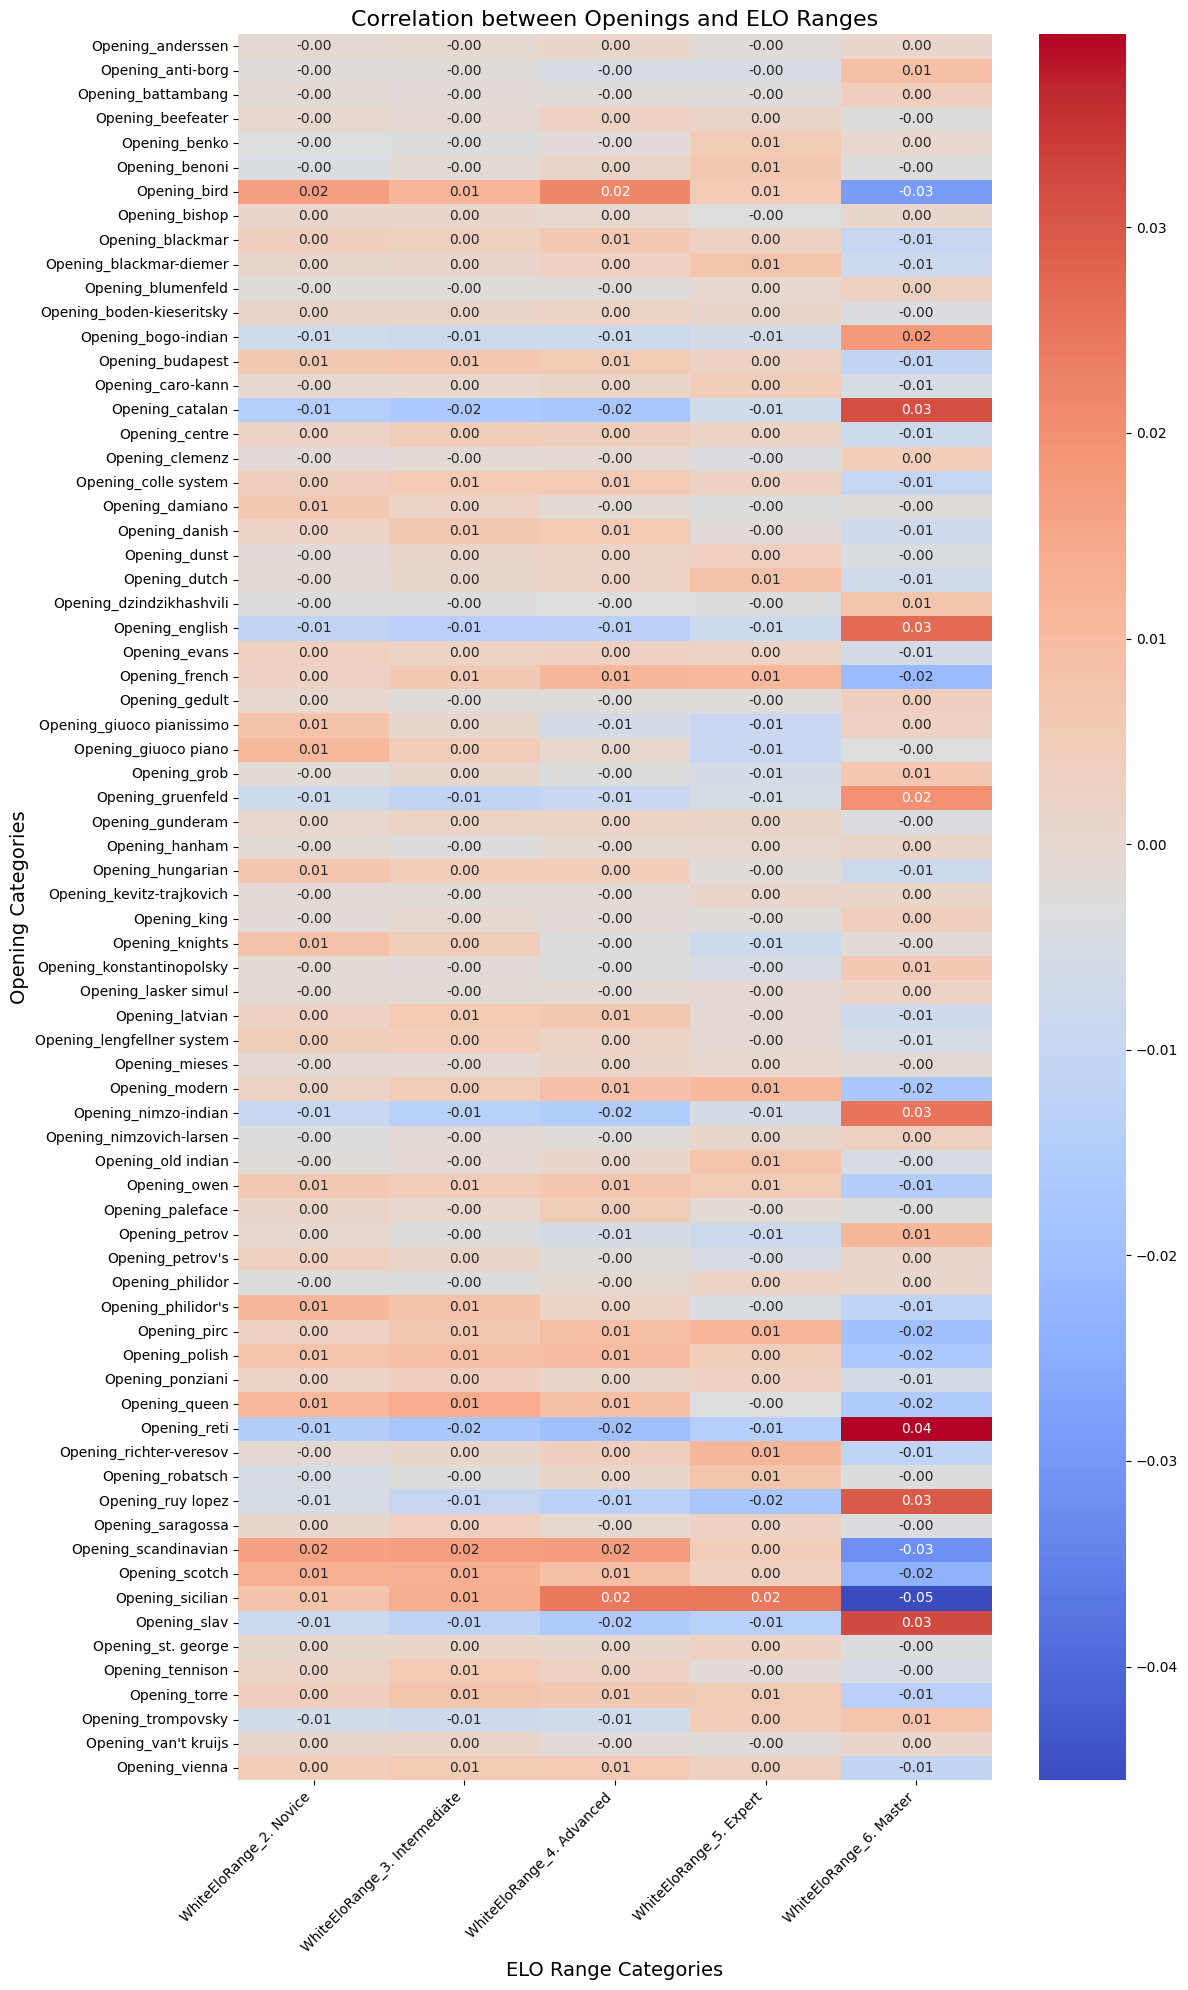

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Define a function to categorize ELO into ranges
def categorize_elo(elo):
    if elo < 1400:
        return '1. Beginner'
    elif 1400 <= elo < 1600:
        return '2. Novice'
    elif 1600 <= elo < 1800:
        return '3. Intermediate'
    elif 1800 <= elo < 2000:
        return '4. Advanced'
    elif 2000 <= elo < 2200:
        return '5. Expert'
    else:
        return '6. Master'

# Step 2: Apply the function to both 'WhiteElo' and 'BlackElo' columns
chess_data['WhiteEloRange'] = chess_data['WhiteElo'].apply(categorize_elo)

# Apply one-hot encoding with a custom order for WhiteEloRange
chess_data_encoded_elo = pd.get_dummies(chess_data[['Opening', 'WhiteEloRange']], drop_first=True)

# Step 5: Extract the relevant one-hot encoded columns (for Opening and WhiteEloRange)
opening_columns_elo = [col for col in chess_data_encoded_elo.columns if col.startswith('Opening')]
elo_columns = [col for col in chess_data_encoded_elo.columns if col.startswith('WhiteEloRange')]

# Step 6: Calculate the correlation matrix for these groups
correlation_subset_elo = chess_data_encoded_elo[opening_columns_elo + elo_columns].corr()

# Step 7: Extract only the correlations between Opening and ELO ranges
correlation_between_opening_and_elo = correlation_subset_elo.loc[opening_columns_elo, elo_columns]

# Step 8: Plot the correlation heatmap with a larger figure size
plt.figure(figsize=(12, 20))  # Increase the size of the plot
sns.heatmap(correlation_between_opening_and_elo, cmap='coolwarm', annot=True, cbar=True, fmt='.2f')

# Step 9: Rotate axis labels for better readability
plt.title('Correlation between Openings and ELO Ranges', fontsize=16)
plt.xlabel('ELO Range Categories', fontsize=14)
plt.ylabel('Opening Categories', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Step 10: Display the plot
plt.tight_layout()
plt.show()

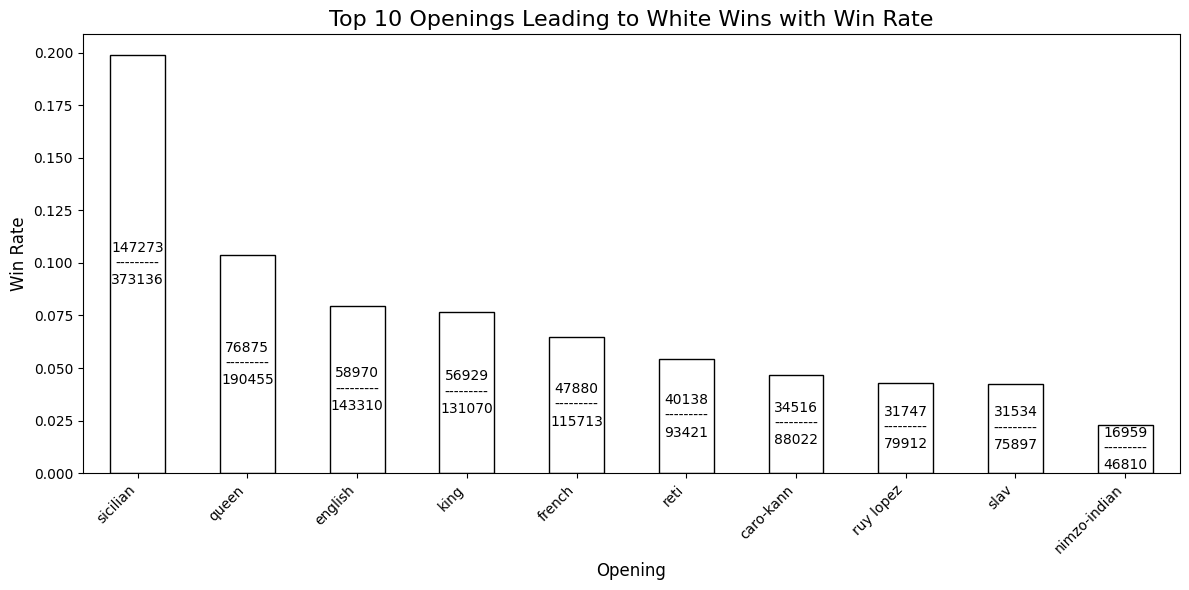

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Filter the data for games where White wins
white_wins = chess_data[chess_data['Winner'] == 'white']

# Step 2: Group by Opening and calculate the win rate for each opening
opening_win_rates = white_wins['Opening'].value_counts(normalize=True)

# Step 3: Select the top 10 openings with the highest win rate
top_10_openings = opening_win_rates.head(10)

# Step 4: Calculate the number of wins and total games for each opening
top_10_openings_count = white_wins['Opening'].value_counts().loc[top_10_openings.index]
total_games_for_opening = chess_data['Opening'].value_counts().loc[top_10_openings.index]

# Step 5: Plot the data
plt.figure(figsize=(12, 6))
ax = top_10_openings.plot(kind='bar', color='white', edgecolor='black')

# Step 6: Add text annotations to each bar
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        # Get the index for the current bar
        opening = p.get_x() + p.get_width() / 2
        opening_name = top_10_openings.index[int(opening)]

        # Get win count and total games for the opening
        num_wins = top_10_openings_count[opening_name]
        total_games = total_games_for_opening[opening_name]

        # Place the annotation
        ax.text(
            p.get_x() + p.get_width() / 2,  # Center of the bar
            p.get_y() + height / 2,        # Center of the bar's height
            f'{num_wins}\n---------\n{total_games}',   # Number text (wins/total games)
            ha='center', va='center',
            color='white' if p.get_facecolor() == (0, 0, 1, 1) else 'black'  # Adjust color for visibility
        )

# Step 7: Customize the plot
plt.title('Top 10 Openings Leading to White Wins with Win Rate', fontsize=16)
plt.xlabel('Opening', fontsize=12)
plt.ylabel('Win Rate', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Step 8: Display the plot
plt.show()

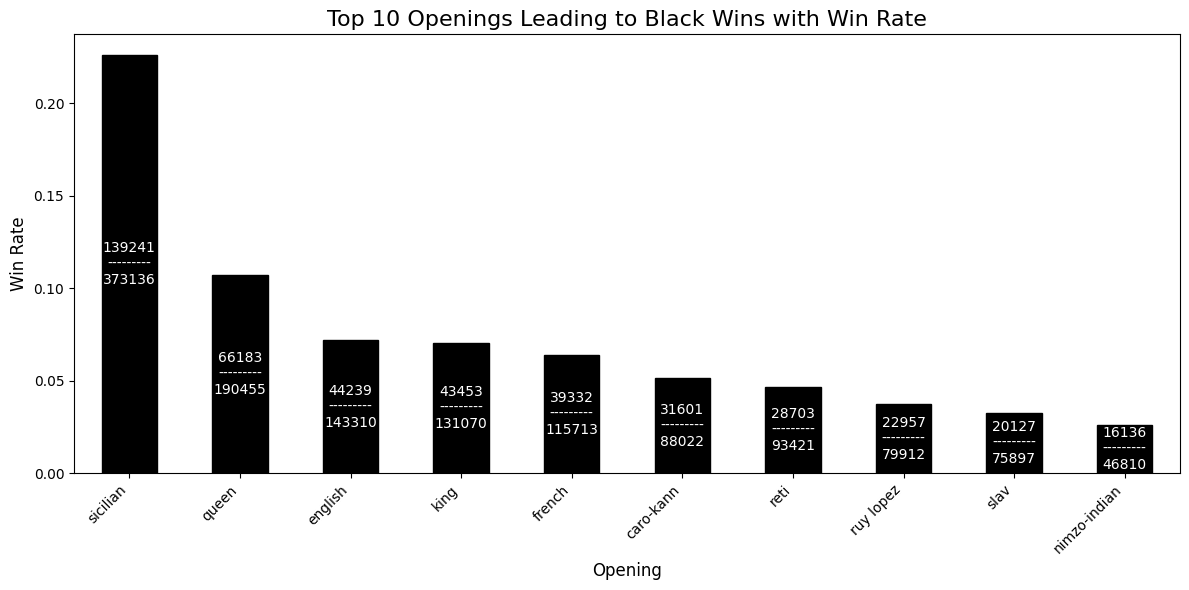

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Filter the data for games where Black wins
black_wins = chess_data[chess_data['Winner'] == 'black']

# Step 2: Group by Opening and calculate the win rate for each opening
opening_win_rates_black = black_wins['Opening'].value_counts(normalize=True)

# Step 3: Select the top 10 openings with the highest win rate for Black
top_10_openings_black = opening_win_rates_black.head(10)

# Step 4: Calculate the number of wins and total games for each opening
top_10_openings_count_black = black_wins['Opening'].value_counts().loc[top_10_openings_black.index]
total_games_for_opening_black = chess_data['Opening'].value_counts().loc[top_10_openings_black.index]

# Step 5: Plot the data for Black
plt.figure(figsize=(12, 6))
ax_black = top_10_openings_black.plot(kind='bar', color='black', edgecolor='black')

# Step 6: Add text annotations to each bar for Black
for p in ax_black.patches:
    height = p.get_height()
    if height > 0:
        # Get the index for the current bar
        opening = p.get_x() + p.get_width() / 2
        opening_name = top_10_openings_black.index[int(opening)]

        # Get win count and total games for the opening
        num_wins = top_10_openings_count_black[opening_name]
        total_games = total_games_for_opening_black[opening_name]

        # Place the annotation
        ax_black.text(
            p.get_x() + p.get_width() / 2,  # Center of the bar
            p.get_y() + height / 2,        # Center of the bar's height
            f'{num_wins}\n---------\n{total_games}',   # Number text (wins/total games)
            ha='center', va='center',
            color='white'
        )

# Step 7: Customize the plot for Black
plt.title('Top 10 Openings Leading to Black Wins with Win Rate', fontsize=16)
plt.xlabel('Opening', fontsize=12)
plt.ylabel('Win Rate', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Step 8: Display the plot for Black
plt.show()

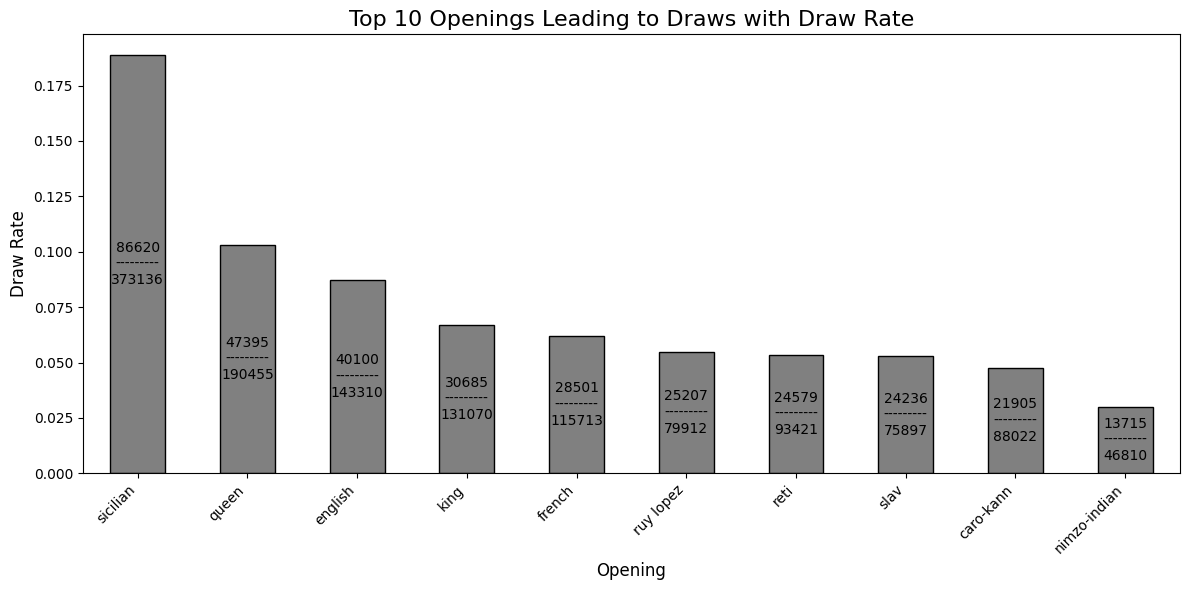

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Filter the data for games that ended in a draw
draws = chess_data[chess_data['Winner'] == 'tie']

# Step 2: Group by Opening and calculate the draw rate for each opening
opening_draw_rates = draws['Opening'].value_counts(normalize=True)

# Step 3: Select the top 10 openings with the highest draw rate
top_10_openings_draw = opening_draw_rates.head(10)

# Step 4: Calculate the number of draws and total games for each opening
top_10_openings_count_draw = draws['Opening'].value_counts().loc[top_10_openings_draw.index]
total_games_for_opening_draw = chess_data['Opening'].value_counts().loc[top_10_openings_draw.index]

# Step 5: Plot the data for draws
plt.figure(figsize=(12, 6))
ax_draw = top_10_openings_draw.plot(kind='bar', color='gray', edgecolor='black')

# Step 6: Add text annotations to each bar for draws (with white text)
for p in ax_draw.patches:
    height = p.get_height()
    if height > 0:
        # Get the index for the current bar
        opening = p.get_x() + p.get_width() / 2
        opening_name = top_10_openings_draw.index[int(opening)]

        # Get draw count and total games for the opening
        num_draws = top_10_openings_count_draw[opening_name]
        total_games = total_games_for_opening_draw[opening_name]

        # Place the annotation with white text
        ax_draw.text(
            p.get_x() + p.get_width() / 2,  # Center of the bar
            p.get_y() + height / 2,        # Center of the bar's height
            f'{num_draws}\n---------\n{total_games}',   # Number text (draws/total games)
            ha='center', va='center',
            color='black'  # White text color
        )

# Step 7: Customize the plot for draws
plt.title('Top 10 Openings Leading to Draws with Draw Rate', fontsize=16)
plt.xlabel('Opening', fontsize=12)
plt.ylabel('Draw Rate', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Step 8: Display the plot for draws
plt.show()


### Correlation between country and winner result

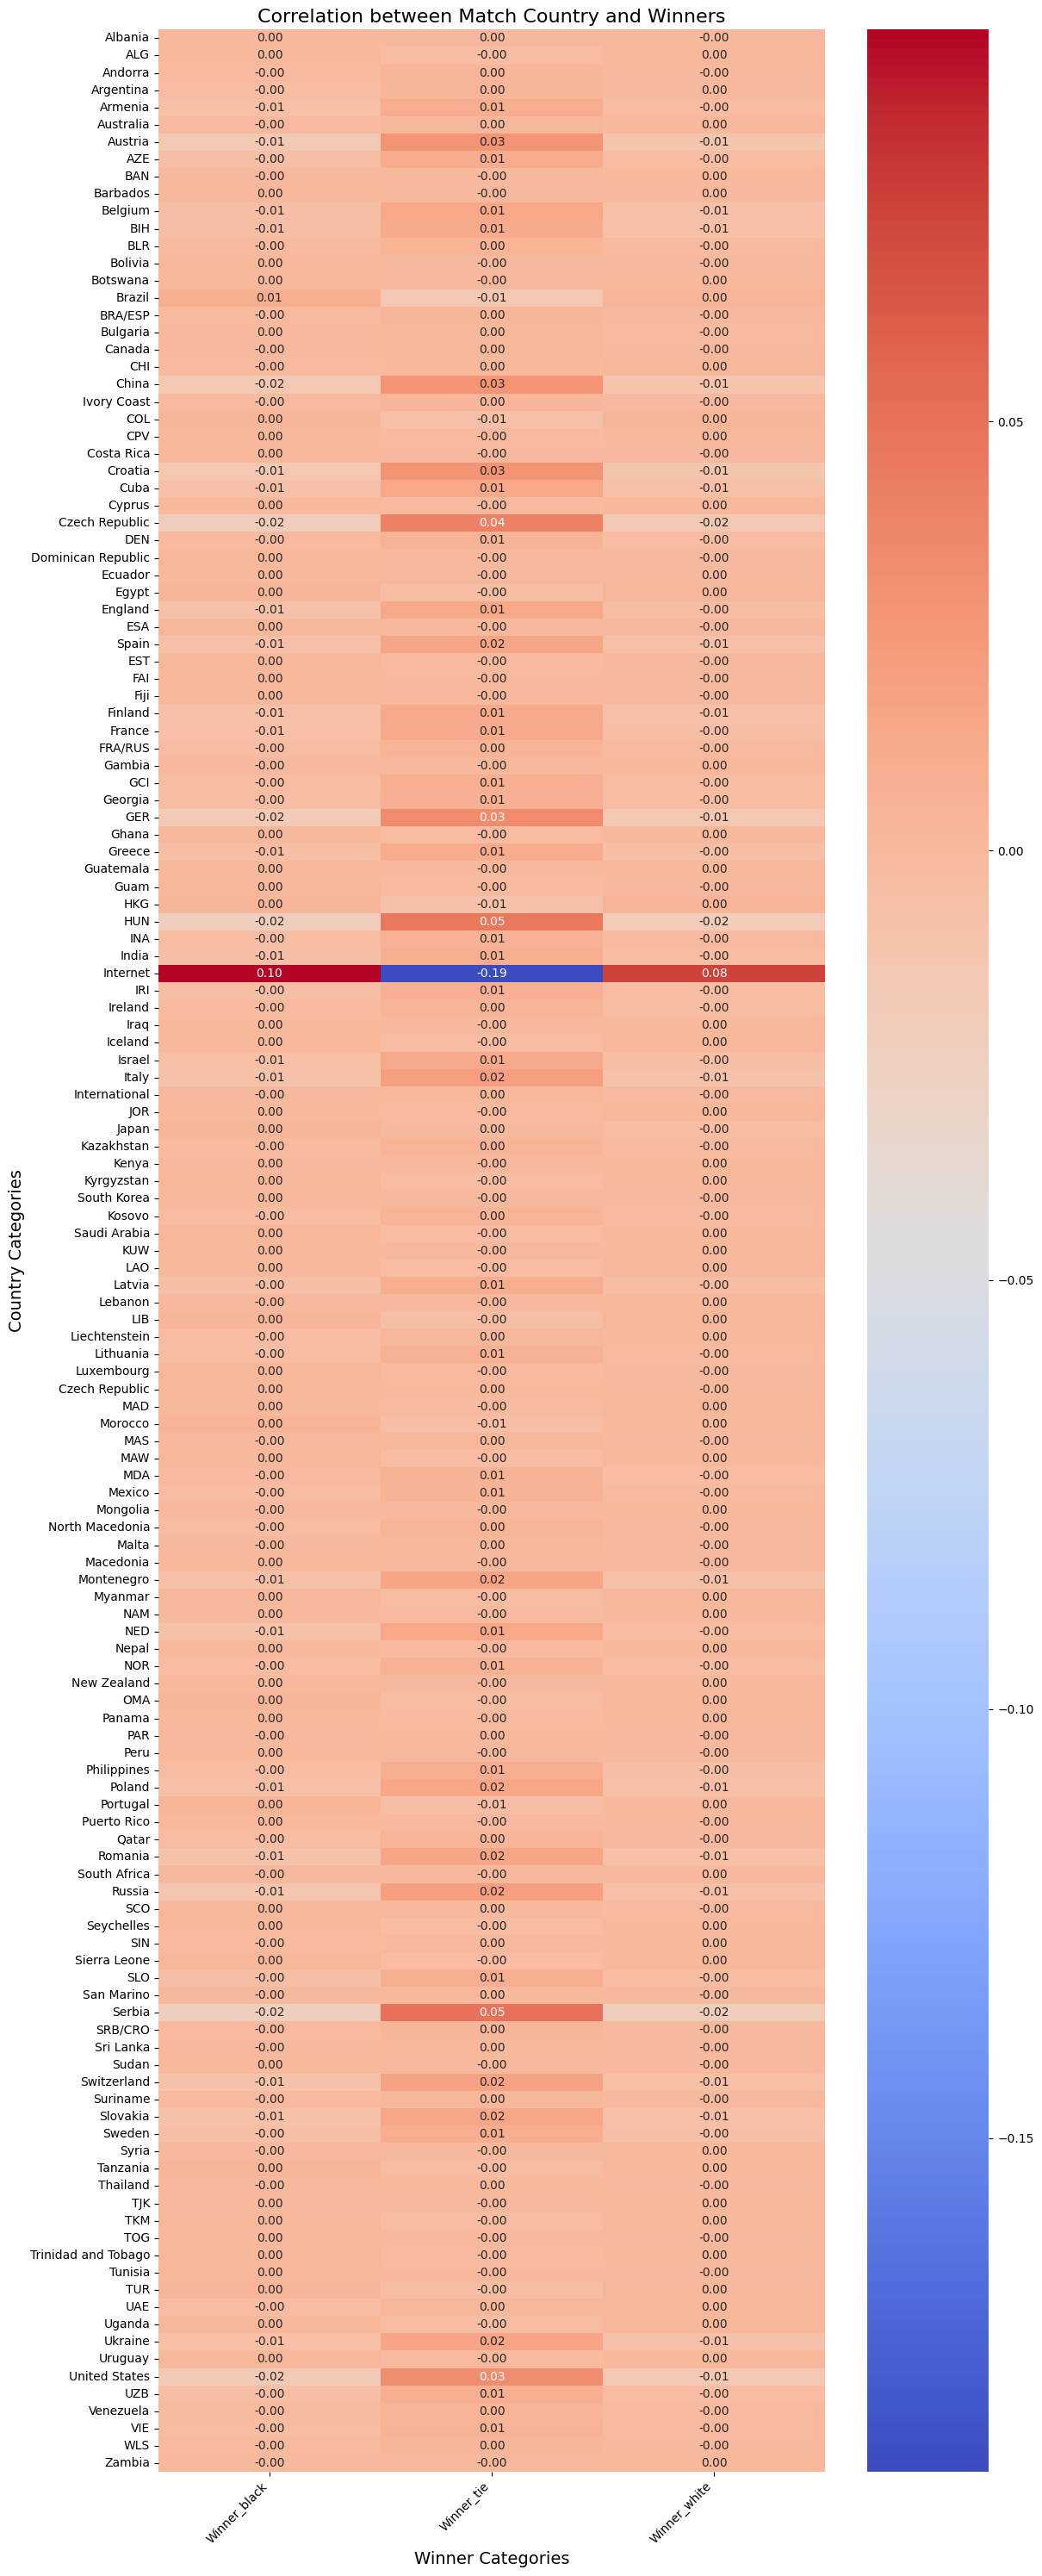

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

country_code_to_name = {
    "RUS": "Russia", "ITA": "Italy", "FRA": "France", "DEU": "Germany", "ESP": "Spain", "INT": "Internet",
    "GBR": "United Kingdom", "USA": "United States", "CAN": "Canada", "AUS": "Australia",
    "CHN": "China", "IND": "India", "BRA": "Brazil", "JPN": "Japan", "KOR": "South Korea",
    "ARG": "Argentina", "MEX": "Mexico", "POL": "Poland", "NLD": "Netherlands", "BEL": "Belgium",
    "SWE": "Sweden", "SUI": "Switzerland", "UKR": "Ukraine", "FIN": "Finland", "AUT": "Austria",
    "CZE": "Czech Republic", "CHL": "Chile", "LIT": "Lithuania", "LAT": "Latvia", "THA": "Thailand",
    "ISR": "Israel", "IRL": "Ireland", "CRO": "Croatia", "ROU": "Romania", "BUL": "Bulgaria",
    "KAZ": "Kazakhstan", "GEO": "Georgia", "GRE": "Greece", "POR": "Portugal", "ISL": "Iceland",
    "MNE": "Montenegro", "SRB": "Serbia", "MKD": "North Macedonia", "ARM": "Armenia", "NZL": "New Zealand",
    "UGA": "Uganda", "URU": "Uruguay", "PER": "Peru", "CUB": "Cuba", "RSA": "South Africa",
    "KSA": "Saudi Arabia", "LBN": "Lebanon", "DOM": "Dominican Republic", "KOS": "Kosovo", "BOL": "Bolivia",
    "TUN": "Tunisia", "MAR": "Morocco", "SUD": "Sudan", "NEP": "Nepal", "EGY": "Egypt", "GHA": "Ghana",
    "IRQ": "Iraq", "VEN": "Venezuela", "KEN": "Kenya", "PHI": "Philippines", "QAT": "Qatar", "SRI": "Sri Lanka",
    "FIJ": "Fiji", "ZAM": "Zambia", "CIV": "Ivory Coast", "PAN": "Panama", "LUX": "Luxembourg",
    "ECU": "Ecuador", "LIE": "Liechtenstein", "TRI": "Trinidad and Tobago", "CRC": "Costa Rica", "CYP": "Cyprus",
    "PUR": "Puerto Rico", "GAM": "Gambia", "MLT": "Malta", "SLE": "Sierra Leone", "GUA": "Guatemala",
    "SVK": "Slovakia", "ENG": "England", "JCI": "International", "Labem": "Czech Republic", "BAR": "Barbados",
    "AND": "Andorra", "KOS": "Kosovo", "LTU": "Lithuania", "BOL": "Bolivia", "TUN": "Tunisia", "ALB": "Albania",
    "TAN": "Tanzania", "MGL": "Mongolia", "KGZ": "Kyrgyzstan", "SUR": "Suriname", "MYA": "Myanmar",
    "MNC": "Macedonia", "SMR": "San Marino", "SYR": "Syria", "SEY": "Seychelles", "GUM": "Guam", "BOT": "Botswana"
}

# Step 1: One-hot encode the 'Country' and 'Winner' columns
chess_data_encoded = pd.get_dummies(chess_data[['Country', 'Winner']], columns=['Country', 'Winner'])

# Step 2: Extract the relevant one-hot encoded columns (only the ones for Country and Winner)
country_columns = [col for col in chess_data_encoded.columns if col.startswith('Country')]
winner_columns = [col for col in chess_data_encoded.columns if col.startswith('Winner')]

# Step 3: Calculate the correlation matrix only for these two groups
correlation_subset = chess_data_encoded[country_columns + winner_columns].corr()

# Step 4: Extract only the correlations between Country and Winner columns
correlation_between_country_and_winner = correlation_subset.loc[country_columns, winner_columns]

# Step 6: Plot the correlation heatmap with a larger figure size
plt.figure(figsize=(12, 30))
sns.heatmap(correlation_between_country_and_winner, cmap='coolwarm', annot=True, cbar=True, fmt='.2f')

# Step 7: Rotate axis labels for better readability
plt.title('Correlation between Match Country and Winners', fontsize=16)
plt.xlabel('Winner Categories', fontsize=14)
plt.ylabel('Country Categories', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Step 8: Display the plot
plt.tight_layout()
plt.show()

### Correlation between Elo difference and winner result

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Calculate the Elo difference
chess_data['Elo_Diff'] = chess_data['WhiteElo'] - chess_data['BlackElo']

# Step 2: Convert the Winner column to numeric (1 for white wins, 0 for black wins, and 0.5 for tie)
chess_data['Winner_Numeric'] = chess_data['Result'].apply(lambda x: 1 if x == '1-0' else (0 if x == '0-1' else 0.5))

# Step 3: Calculate the Pearson correlation between Elo difference and Winner
correlation = chess_data[['Elo_Diff', 'Winner_Numeric']].corr().iloc[0, 1]

# Step 4: Display correlation and explanation
print(f"Correlation between Elo Difference and Winner Result: {correlation:.2f}")

# Explanation of what the correlation means
if correlation > 0:
    print(f"The positive correlation ({correlation:.2f}) suggests that as the Elo difference in favor of White increases, White is more likely to win.")
elif correlation < 0:
    print(f"The negative correlation ({correlation:.2f}) suggests that as the Elo difference in favor of White increases, Black is more likely to win, indicating potential upsets.")
else:
    print(f"The correlation is approximately 0 ({correlation:.2f}), suggesting that Elo difference does not strongly affect the winner, implying that other factors (such as strategy, form, etc.) are more influential.")

Correlation between Elo Difference and Winner Result: 0.48
The positive correlation (0.48) suggests that as the Elo difference in favor of White increases, White is more likely to win.
